# KNN

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

RANDOM_STATE = 19 * 103785

In [3]:
from preprocesamiento import feature_engineering
from preprocesamiento import obtenerDFHoldout, obtenerDFTraining
from preprocesamiento import preprocesar_data_frame
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## Trabajo Práctico 2: KNN

La idea de este modelo es dado una nueva instancia devuelve la clase mayoritaria dada una cantidad de vecinos fijo(K). Para buscar los mejores hiperparametro utilizaremos GridSearch con un k-fold de 10.

+ n_neighbors: La cantidad de vecinos mas cercanos que debe ser tomados en cuanta para predecir la nueva instancia.

+ weights : La importancia que se le debe dar a cada vecino. Si es 'distance' su importancia es la inversa de su disancia a la instancia a predecir y si es 'uniform' todas valen lo mismo.

+ algorithm : Utilizado para calcular los vecinos más cercanos

+ p : Cuando p = 1, esto equivale a usar manhattan_distance (l1) y euclidean_distance (l2) para p = 2.

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA


# Imprime las metricas Recall, Precision, Accuracy, Roc-auc y muestra la matriz de confuncion.
def metricas(y_real, y_pred, x_test, modelo):

    data = {'y_real': y_real,
            'y_pred': y_pred}

    df_metricas = pd.DataFrame(data, columns=['y_real','y_pred'])
    confusion_matrix = pd.crosstab(df_metricas['y_real'], df_metricas['y_pred'], rownames=['Real'], colnames=['Predicho'])
    sns.heatmap(confusion_matrix, annot=True, fmt="d")
    plt.show()

    print("Recall: {}".format(recall_score(y_real, y_pred).round(2)))
    print("Precision: {}".format(precision_score(y_real, y_pred).round(2)))
    print("Acc: {}".format(accuracy_score(y_real, y_pred).round(2)))
    print("Roc: {}".format(roc_auc_score(y_real, modelo.predict_proba(x_test)[:, 1]).round(2)))
    
    
def preprocesar_standar_scaler(X : pd.DataFrame):
    scaler = StandardScaler()
    scaler.fit(X)
    return scaler.transform(X)

def prepros_dummies_KNN(data):
    data_prepos = pd.get_dummies(data[['ganancia_perdida_declarada_bolsa_argentina','trabajo',
                                      'estado_marital','genero',"anios_estudiados","edad"]])
    
    data_prepos = data_prepos.drop(['trabajo_No contesto'],axis = 1)
    data_prepos = data_prepos.drop(['genero_mujer'],axis = 1)
    data_prepos = data_prepos.drop(['estado_marital_divorciado'],axis = 1)
    
    data_prepos = preprocesar_standar_scaler(data_prepos)

    return data_prepos

Inicialmente preprocesamos el dataset seleccionamos las variables más relevantes y aplicamos a "ganacia_declarada_en_bolsa" una estandarización ya que es una variable con mucha varianza.

In [17]:
df = obtenerDFTraining()
(X,y) = preprocesar_data_frame(df)
X_prepos= prepros_dummies_KNN(X)

X_train, X_test, y_train, y_test = train_test_split(X_prepos, y, test_size=0.25, random_state=RANDOM_STATE)

In [19]:
parametros = {'n_neighbors' : range(5,100,5),'weights':['uniform','distance'],
              'algorithm':['auto','kd_tree','brute'],'p':[1,2]}

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parametros,n_jobs =-1,verbose = 4, scoring = 'roc_auc', cv= 10)

clf.fit(X_train,y_train)
print(classification_report(y_test,clf.predict(X_test)))
clf.best_params_

Fitting 10 folds for each of 228 candidates, totalling 2280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed: 33.7min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 49.4min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 57.6min
[Parallel(n_jobs=-1)]: Done 2280 out of 2280 | elapsed: 63.0min finished


              precision    recall  f1-score   support

           0       0.86      0.93      0.89      6196
           1       0.70      0.50      0.58      1936

    accuracy                           0.83      8132
   macro avg       0.78      0.72      0.74      8132
weighted avg       0.82      0.83      0.82      8132



{'algorithm': 'auto', 'n_neighbors': 40, 'p': 1, 'weights': 'uniform'}

Como podemos ver nuestro primer modelo clasifica correctamente la mitad de las personas con poder adquisitivo alto, sin embargo logra separar bastante bien a las personas con bajo poder adquisitivo, clasificando la gran mayoría correctamente.

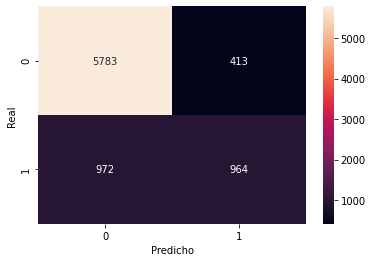

Recall: 0.5
Precision: 0.7
Acc: 0.83
Roc: 0.88


In [39]:
knn = KNeighborsClassifier(algorithm = 'auto', n_neighbors = 40, p = 1, weights = 'uniform')

knn.fit(X_train,y_train)
metricas(y_test,knn.predict(X_test),X_test,knn)

## Otro preprocesamiento (PCA)

El objetivo es utilizar una herramienta de reducción de dimensionalidad para intentar mejorar nuestros resultados. Inicialmente hacemos PCA utilizando todo el dataset y luego seleccionando las variables, que por lo visto en la parte uno, son más relevantes para la clasificación.

In [42]:
def preprocesar_df_min_max_scaler(X : pd.DataFrame):
    X = pd.get_dummies(X)
    scaler = MinMaxScaler()
    scaler.fit(X)
    return scaler.transform(X)

def preprocesar_df_pca(df , dim):
    Y = df['tiene_alto_valor_adquisitivo']
    X = df.drop(columns=['tiene_alto_valor_adquisitivo'])
    X = preprocesar_df_min_max_scaler(X)
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=RANDOM_STATE)
    
    pca = PCA(dim)
    x_train_pca = pd.DataFrame(pca.fit_transform(x_train))
    x_test_pca = pca.transform(x_test)
    
    return (x_train_pca,x_test_pca,y_train,y_test)

df = obtenerDFTraining()
x_train, x_test, y_train, y_test  = preprocesar_df_pca(df,30)

In [44]:
parametros = {'n_neighbors' : range(5,100,5),'weights':['uniform','distance'],
              'algorithm':['auto','kd_tree','brute'],'p':[1,2]}

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parametros,n_jobs =-1,verbose = 4, scoring = 'roc_auc', cv= 10)

clf.fit(x_train,y_train)
print(classification_report(y_test,clf.predict(x_test)))
clf.best_params_

Fitting 10 folds for each of 228 candidates, totalling 2280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 33.6min
[Parallel(n_jobs=-1)]: Done 2280 out of 2280 | elapsed: 38.1min finished


              precision    recall  f1-score   support

           0       0.87      0.91      0.89      6196
           1       0.67      0.56      0.61      1945

    accuracy                           0.83      8141
   macro avg       0.77      0.74      0.75      8141
weighted avg       0.82      0.83      0.82      8141



{'algorithm': 'brute', 'n_neighbors': 50, 'p': 1, 'weights': 'uniform'}

Como podemos ver nuestro nuevo modelo pierde precisión pero aumento su recall para clasificar los unos.

Ahora por último haremos PCA pero sobre un dataset reducido con los mismos features que en el primer modelo.

In [47]:
df = obtenerDFTraining()
x_train, x_test, y_train, y_test  = preprocesar_df_pca(df[['ganancia_perdida_declarada_bolsa_argentina','trabajo',
                                      'estado_marital','genero',"anios_estudiados","tiene_alto_valor_adquisitivo"]],18)

parametros = {'n_neighbors' : range(5,100,5),'weights':['uniform','distance'],
              'algorithm':['auto','kd_tree','brute'],'p':[1,2]}

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parametros,n_jobs =-1,verbose = 4, scoring = 'roc_auc', cv= 10)

clf.fit(x_train,y_train)
print(classification_report(y_test,clf.predict(x_test)))
clf.best_params_

Fitting 10 folds for each of 228 candidates, totalling 2280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 2280 out of 2280 | elapsed: 11.7min finished


              precision    recall  f1-score   support

           0       0.87      0.94      0.90      6196
           1       0.73      0.56      0.63      1945

    accuracy                           0.85      8141
   macro avg       0.80      0.75      0.77      8141
weighted avg       0.84      0.85      0.84      8141



{'algorithm': 'brute', 'n_neighbors': 85, 'p': 1, 'weights': 'distance'}

Como podemos notar mejorar las métricas con respecto a los demás posibles modelos. De modo que decidimos presentarlo como modelo final de KNN.

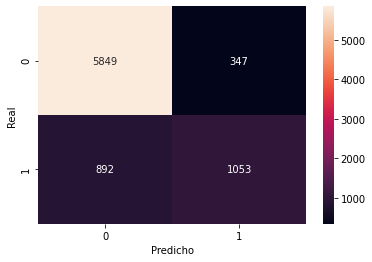

Recall: 0.54
Precision: 0.75
Acc: 0.85
Roc: 0.88


In [49]:
df = obtenerDFTraining()
x_train, x_test, y_train, y_test  = preprocesar_df_pca(df[['ganancia_perdida_declarada_bolsa_argentina','trabajo',
                                      'estado_marital','genero',"anios_estudiados","tiene_alto_valor_adquisitivo"]],18)

knn = KNeighborsClassifier( algorithm = 'brute', n_neighbors = 85, p = 1, weights = 'distance')

knn.fit(x_train,y_train)

metricas(y_test,knn.predict(x_test),x_test,knn)